### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# tokenization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# stopword removal
import nltk
import string
import re
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

# Vectorization/Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Neural Networks
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dropout, Input, Dense 
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed


datapath = 'data/'

2022-01-22 18:19:57.765395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 18:19:57.765435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load Data

In [2]:
data = pd.read_csv(datapath + 'disaster_train.csv', sep=',',)

### Descriptives

In [3]:
print('Missing keywords:', sum(data['keyword'].isna()))
print('Missing locations:', sum(data['location'].isna()))

Missing keywords: 61
Missing locations: 2533


Out of those 7613 61 do not have a keyword an 2533 do not have a location


In [4]:
data_bool = data.copy().loc[:, 'keyword':'target']
data_bool['keyword'] = data_bool['keyword'].isna()
data_bool['location'] = data_bool['location'].isna()
data_bool['count'] = np.ones(data.shape[0], dtype=int)

summ = data_bool.groupby('target').sum()
summ['location_ratio'] = summ['location']/summ['count']
print(summ)

        keyword  location  count  location_ratio
target                                          
0            19      1458   4342        0.335790
1            42      1075   3271        0.328646


Grouping by target, there are 4342 fake tweets (target: 0) and 3271 real tweets (target: 1). The ratio of missing locations is similar, the amount of missing keyqwords is negligibly different. 

### Tokenize data

we extract the text of the tweets as X vector and the transform them into a `tf-idf` (term-frequency times inverse document-frequency) matrix. 


In [5]:
# split feature vector and target vector
Y = data["target"].values 
X = data.values[:, 1:4]

# Get only column with tweet text and keywords
x_tweets = data['text']
x_keywords = data['keyword'].fillna('nan')
print(x_keywords.head())
print(x_tweets.head())

0    nan
1    nan
2    nan
3    nan
4    nan
Name: keyword, dtype: object
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


In [6]:
# Tweet tokenizer for making all alphabetical symbols lowercase, reducing length of words
# if they are e.g. 'goaaaal' and for removing account handles
tknzr = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
tweet_tokens = []
for sent in x_tweets:
    #print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tknzr.tokenize(sent))
print(tweet_tokens[:2])

[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]


In [7]:
# clean out stopwords, # signs, punctuation and numbers
clean_t2 = [[word if (word.startswith('#') == False) else re.sub(r'#', '', word) for word in tweet] for tweet in tweet_tokens]
clean_t3 = [[word for word in tweet if (word not in string.punctuation) and (word.isalpha() == True) and (word not in english_stopwords)] for tweet in clean_t2]
clean_t3[:2]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

In [8]:
# Transform into correct input form for the Vectorizer
clean_t4 = [' '.join(tweet) for tweet in clean_t3]
x_tweets = np.array(clean_t4)
x_tweets[:2]

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada'], dtype='<U138')

In [9]:
# stack preprocessed tweets and keywords back together
x_tweets_keywords = np.stack((x_tweets, x_keywords), axis=1)

In [10]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(x_tweets_keywords, Y, test_size=0.15, random_state=42, shuffle=True)

# create tf-idf vectorizer
tf_computer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))

# vectorize train and test set
train_features_tweets = tf_computer.fit_transform(X_train[:, 0])
test_features_tweets = tf_computer.transform(X_test[:, 0])
print("vocabulary size tweets:", len(tf_computer.vocabulary_))

train_features_keywords = tf_computer.fit_transform(X_train[:, 1])
test_features_keywords = tf_computer.transform(X_test[:, 1])
print("vocabulary size keywords:", len(tf_computer.vocabulary_))

# stack features together
train_features = hstack((train_features_tweets, train_features_keywords))
test_features = hstack((test_features_tweets, test_features_keywords))

vocabulary size tweets: 48914
vocabulary size keywords: 277


# Linear Classifiers
In the following we are going to try out different Linear Classifiers provided by sklearn. For each of those we will perform a gridsearch on the main parameters and print out the F1 score for the best fit. Following we will use the different simple classifiers to build one ensemle classifier.

In [11]:
# crreate dataframe to save results of the different classifiers to
results = pd.DataFrame({
    'model': [],
    'f1_train': [],
    'f1_test': []
})

### Logistic Regression

In [12]:
# define grid search parameters 
logreg_params = {
    'C': [0.5, 1, 5, 10, 100, 500],
}

clf = LogisticRegression(random_state=42, max_iter=1000)
clf_grid_logreg = GridSearchCV(estimator=clf, param_grid=logreg_params, cv = 5, n_jobs=-1)
clf_grid_logreg.fit(train_features, y_train) 

#see the best parameters and performance
print(clf_grid_logreg.best_params_)
print(clf_grid_logreg.best_score_)

# check the f1 score
y_train_pred = clf_grid_logreg.predict(train_features)
y_test_pred = clf_grid_logreg.predict(test_features)

f1_train = np.round(f1_score(y_train, y_train_pred,average = 'macro'), 3)
f1_test = np.round(f1_score(y_test, y_test_pred,average = 'macro'), 3)

# append results
results = results.append(pd.Series(['LogisticRegression', f1_train, f1_test], index=results.columns), ignore_index=True)

print(f"Logistic Regression: \tTrain:{f1_train:.4f}\tTest:{f1_test:.4f}")

{'C': 10}
0.7892135367869526
Logistic Regression: 	Train:0.9840	Test:0.7810


### Check results for systematic errors

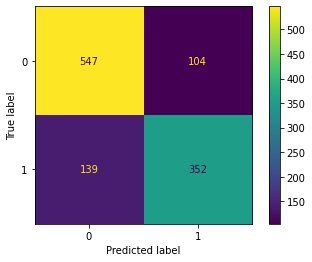

In [13]:
cm = confusion_matrix(y_test, y_test_pred, labels=clf_grid_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_grid_logreg.classes_)
disp.plot()

Relatively evenly distributed errors on the test set.

### SVC

In [14]:
#train the svc
svc_params = {
    'C': (0.1, 1., 10),
    'kernel': ('rbf', 'linear'),
}

clf = SVC(random_state=42)
clf_grid_svc = GridSearchCV(clf, svc_params, cv = 5, n_jobs= -1)
clf_grid_svc.fit(train_features, y_train)

# check the f1 score
y_train_pred = clf_grid_svc.predict(train_features)
y_test_pred = clf_grid_svc.predict(test_features)

f1_train = np.round(f1_score(y_train, y_train_pred,average = 'macro'), 3)
f1_test = np.round(f1_score(y_test, y_test_pred,average = 'macro'), 3)

# append results
results = results.append(pd.Series(['SVC', f1_train, f1_test], index=results.columns), ignore_index=True)

print(f"SVM: \tTrain:{f1_train:.4f}\tTest:{f1_test:.4f}")

SVM: 	Train:0.9590	Test:0.7800


### RidgeClassifier

In [15]:
# select a linear model based on the assumption that specific words (linearly) imply a real disaster or not
ridge_params = {
    'alpha': (0.1, 1, 10),
    'fit_intercept': (True, False)
}

clf = RidgeClassifier(random_state=42)
clf_grid_ridge = GridSearchCV(clf, ridge_params, cv=5, n_jobs=-1)
clf_grid_ridge.fit(train_features, y_train)

# check the f1 score
y_train_pred = clf_grid_ridge.predict(train_features)
y_test_pred = clf_grid_ridge.predict(test_features)

f1_train = np.round(f1_score(y_train, y_train_pred,average = 'macro'), 3)
f1_test = np.round(f1_score(y_test, y_test_pred,average = 'macro'), 3)

# append results
results = results.append(pd.Series(['RidgeClassifier', f1_train, f1_test], index=results.columns), ignore_index=True)

print(f"Ridge Classifier F1: \tTrain:{f1_train:.4f}\tTest:{f1_test:.4f}")

Ridge Classifier F1: 	Train:0.9870	Test:0.7760


### RandomForest

In [16]:
# we start with a grid search on a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
forest_params = {
    'n_estimators': (100, 500),
    'max_depth': [500]
}

# perform gridsearch
clf = RandomForestClassifier(random_state=42)
clf_grid_forest = GridSearchCV(clf, forest_params, verbose=0, n_jobs=-1)
clf_grid_forest.fit(train_features, y_train)

# check the f1 score
y_train_pred = clf_grid_forest.predict(train_features)
y_test_pred = clf_grid_forest.predict(test_features)

f1_train = np.round(f1_score(y_train, y_train_pred,average = 'macro'), 3)
f1_test = np.round(f1_score(y_test, y_test_pred,average = 'macro'), 3)

# append results
results = results.append(pd.Series(['RandomForest', f1_train, f1_test], index=results.columns), ignore_index=True)

print(f"Random Forest F1: \tTrain:{f1_train:.4f}\tTest:{f1_test:.4f}")

Random Forest F1: 	Train:0.9810	Test:0.7620


### Ensemble Method: StackingClassifier

In [17]:
# lets put together the classifiers for our ensemble using the previously claculated optimal parameters.
estimators = [
    ('rf', RandomForestClassifier(**clf_grid_forest.best_params_, random_state=42)),
    ('svr', SVC(**clf_grid_svc.best_params_, random_state=42)),
    ('ridge', RidgeClassifier(**clf_grid_ridge.best_params_, random_state=42)),
    ('logreg', LogisticRegression(**clf_grid_logreg.best_params_, random_state=42, max_iter=1000))
]

# fit our stacking classifier
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
ensemble_results = cross_validate(clf, train_features, y_train, scoring=['accuracy', 'f1'] , cv=5, n_jobs=-1)

In [18]:
f1_train = np.nan
f1_test = np.round(ensemble_results['test_f1'].mean(), 3)
results = results.append(pd.Series(['Ensemble Learner', f1_train, f1_test], index=results.columns), ignore_index=True)

print(f'Ensemble F1 \t Test:{f1_test:.4f}')

Ensemble F1 	 Test:0.7510


# Neural Network
In this second part we are going to use a sequential neural network for the classification.

### Create early stopping mechanism for NN

In [19]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

np.random.seed(123)
set_random_seed(2)

### Transform data into a suitable input

In [20]:
# change to dense format
train_features_den = train_features.todense()
test_features_den = test_features.todense()
feature_vector_length = train_features_den.shape[1]

# one-hot-encoding of labels
n_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

### Create and fit the NN

In [21]:
import tensorflow as tf
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

2022-01-22 18:31:14.815146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 18:31:14.815165: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 18:31:14.815178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (siprius): /proc/driver/nvidia/version does not exist
2022-01-22 18:31:14.815328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# keras does not provide f1 as a metric during training, so we need to calculate it by hand using precision and recall
# from tensorflow.keras.metrics import Precision, Recall
from keras.models import Sequential

# create model layers
model = Sequential() 
model.add(Dense(input_dim = feature_vector_length, units=200 , activation='relu')) 
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax')) #output layer

# configure the model and start training
model.compile(loss='binary_crossentropy', #loss metric
    optimizer='adam',  #optimizer
    metrics=['accuracy', precision, recall]) #displayed metric

history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=10, verbose=2, validation_split=0.2, callbacks=[es])

2022-01-22 18:31:15.233445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1018450464 exceeds 10% of free system memory.


Epoch 1/10
52/52 - 5s - loss: 0.6035 - accuracy: 0.6953 - precision: 0.6953 - recall: 0.6953 - val_loss: 0.4744 - val_accuracy: 0.7876 - val_precision: 0.7876 - val_recall: 0.7876 - 5s/epoch - 88ms/step
Epoch 2/10
52/52 - 4s - loss: 0.2448 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - val_loss: 0.5002 - val_accuracy: 0.7853 - val_precision: 0.7853 - val_recall: 0.7853 - 4s/epoch - 80ms/step
Epoch 3/10
52/52 - 4s - loss: 0.0803 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - val_loss: 0.5779 - val_accuracy: 0.7792 - val_precision: 0.7792 - val_recall: 0.7792 - 4s/epoch - 83ms/step
Epoch 4/10
52/52 - 5s - loss: 0.0545 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - val_loss: 0.5896 - val_accuracy: 0.7730 - val_precision: 0.7730 - val_recall: 0.7730 - 5s/epoch - 94ms/step
Epoch 00004: early stopping


### Analyse the NN output

In [23]:
history_pd = pd.DataFrame(history.history)
history_pd['f1'] = 2/(1/history_pd.iloc[:, 2] + 1/history_pd.iloc[:, 3])
history_pd['val_f1'] = 2/(1/history_pd.iloc[:, 6] + 1/history_pd.iloc[:, 7])
print(history_pd)

       loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  0.603494  0.695325   0.695325  0.695325  0.474386      0.787645   
1  0.244827  0.906878   0.906878  0.906878  0.500160      0.785328   
2  0.080251  0.972372   0.972372  0.972372  0.577887      0.779151   
3  0.054462  0.978748   0.978748  0.978748  0.589584      0.772973   

   val_precision  val_recall        f1    val_f1  
0       0.787645    0.787645  0.695325  0.787645  
1       0.785328    0.785328  0.906878  0.785328  
2       0.779151    0.779151  0.972372  0.779151  
3       0.772973    0.772973  0.978748  0.772973  


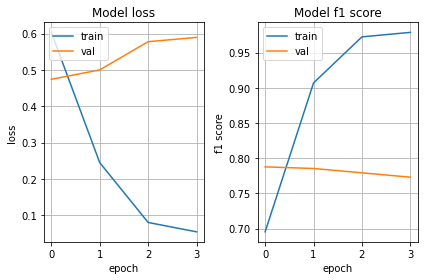

In [24]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(history_pd['loss'])
axes[0].plot(history_pd['val_loss'])
axes[0].set_title('Model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')
axes[0].grid()
# summarize history for accuracy
axes[1].plot(history_pd['f1'])
axes[1].plot(history_pd['val_f1'])
axes[1].set_title('Model f1 score')
axes[1].set_ylabel('f1 score')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')
axes[1].grid()

fig.tight_layout()
     

The training curves show a clear picture: the NN overfits our data. The train loss is reduced constantly and training f1 nealy reaches 0.98 but the validation loss increases over the epochs and validation f1 stays at about 0.78.

In [25]:
y_proba = model.predict(train_features_den)
y_train_pred = y_proba.argmax(axis=-1)

y_proba = model.predict(test_features.todense())
y_test_pred = y_proba.argmax(axis=-1)

f1_train = np.round(f1_score(y_train, y_train_pred), 3)
f1_test = np.round(f1_score(y_test, y_test_pred), 3)
results = results.append(pd.Series(['Neural Network', f1_train, f1_test], index=results.columns), ignore_index=True)


print('Train F1 score:', f1_train)
print('Test F1 score:', f1_test)
print('\nTrain accuracy score:', np.round(accuracy_score(y_train, y_train_pred), 3))
print('Test accuray score:', np.round(accuracy_score(y_test, y_test_pred), 3))

2022-01-22 18:31:34.113833: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1273259844 exceeds 10% of free system memory.


Train F1 score: 0.934
Test F1 score: 0.734

Train accuracy score: 0.943
Test accuray score: 0.766


### Model Variation

In the following section we will try out different depths and activation functions for our model.

In [26]:
# the function can be used in a loop to define several models. The number of units per layer is decreased with every layer 
# to create a "bottleneck"
def MLP_definer(n_layers, n_features, n_classes, activation_f):
    
    model = Sequential()
    model.add(Dense(input_dim = n_features, units=500, activation=activation_f))
    for i in range(1, n_layers):
        model.add(Dense(units=500-10*i^2, activation=activation_f))
        
    model.add(Dense(units=n_classes, activation='softmax'))
    return model

In [27]:
out = {}
for fun in ('relu', 'sigmoid'):
    print(f'\n ## Activation function {fun} ############################################################################')
    for i in range(2,5):    
        model = MLP_definer(i, n_features=feature_vector_length, n_classes=n_classes, activation_f=fun)
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', precision, recall] #displayed metric
        )
        history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=20, verbose=0, validation_split=0.2, callbacks=[es])
        out[i] = [history.history['accuracy'][-1],  history.history['val_accuracy'][-1]]
        print(f'Number of layers: {i} \nTrain Acc: {history.history["accuracy"][-1]} \nTest Acc:  {history.history["val_accuracy"][-1]}\n')


 ## Activation function relu ############################################################################


2022-01-22 18:31:39.447730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1018450464 exceeds 10% of free system memory.


Epoch 00004: early stopping
Number of layers: 2 
Train Acc: 0.9799072742462158 
Test Acc:  0.7760617733001709



2022-01-22 18:32:20.637598: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1018450464 exceeds 10% of free system memory.


Epoch 00004: early stopping
Number of layers: 3 
Train Acc: 0.9793276786804199 
Test Acc:  0.784555971622467



2022-01-22 18:33:01.083434: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1018450464 exceeds 10% of free system memory.


Epoch 00004: early stopping
Number of layers: 4 
Train Acc: 0.9802936911582947 
Test Acc:  0.7791506052017212


 ## Activation function sigmoid ############################################################################
Epoch 00007: early stopping
Number of layers: 2 
Train Acc: 0.9731453061103821 
Test Acc:  0.7930501699447632

Epoch 00008: early stopping
Number of layers: 3 
Train Acc: 0.9781684875488281 
Test Acc:  0.777606189250946

Epoch 00011: early stopping
Number of layers: 4 
Train Acc: 0.9607805013656616 
Test Acc:  0.792277991771698



# Compare F1 scores for all models that were used

In [28]:
print(results)

                model  f1_train  f1_test
0  LogisticRegression     0.984    0.781
1                 SVC     0.959    0.780
2     RidgeClassifier     0.987    0.776
3        RandomForest     0.981    0.762
4    Ensemble Learner       NaN    0.751
5      Neural Network     0.934    0.734
